In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import *
%matplotlib inline

In [3]:
MODELS = [(BertModel,       BertTokenizer,       'bert-base-uncased')]

# To use TensorFlow 2.0 versions of the models, simply prefix the class names with 'TF', e.g. `TFRobertaModel` is the TF 2.0 counterpart of the PyTorch model `RobertaModel`

# Let's encode some text in a sequence of hidden-states using each model:
for model_class, tokenizer_class, pretrained_weights in MODELS:
    # Load pretrained model/tokenizer
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    
    # Encode text
    input_ids = torch.tensor([tokenizer.encode("Here is some text to encode", add_special_tokens=True)])  # Add special tokens takes care of adding [CLS], [SEP], <s>... tokens in the right way for each model.
    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples

### Tokenizer exploration

In [29]:
def token_exploration (x, add_special_tokens=False):
    tok = tokenizer.encode(x, add_special_tokens=add_special_tokens)
    print(x, ", ", tokenizer.tokenize(x), ", ", tok, ",  mida:", len(tok))
    return tok
token_exploration("Here I am", add_special_tokens=True)
token_exploration("Here I am")
token_exploration("Greetings I am")
token_exploration("Hola")
token_exploration("Moi")
token_exploration("ester")
token_exploration("esterno")
token_exploration("esternocli")
token_exploration("esternoclido")
token_exploration("esternoclidomas")
token_exploration("esternoclidomastoidal")
token_exploration("esternoclidomastoidalewq")
token_exploration("create")
token_exploration("created")
token_exploration("create d")
token_exploration("mas")
token_exploration("más")
token_exploration("másede")
token_exploration("ede")
token_exploration("masto")
token_exploration("mastodont")
token_exploration("mastodonts")
token_exploration("mastodonte")
token_exploration("mastodontes")
token_exploration("specialise")
token_exploration("specialize")
token_exploration("length")
token_exploration("lenght")
token_exploration(".")
token_exploration("més.mes")
token_exploration("un")
token_exploration("do")
token_exploration("undo")

Here I am ,  ['here', 'i', 'am'] ,  [101, 2182, 1045, 2572, 102] ,  mida: 5
Here I am ,  ['here', 'i', 'am'] ,  [2182, 1045, 2572] ,  mida: 3
Greetings I am ,  ['greeting', '##s', 'i', 'am'] ,  [14806, 2015, 1045, 2572] ,  mida: 4
Hola ,  ['ho', '##la'] ,  [7570, 2721] ,  mida: 2
Moi ,  ['moi'] ,  [25175] ,  mida: 1
ester ,  ['este', '##r'] ,  [28517, 2099] ,  mida: 2
esterno ,  ['este', '##rno'] ,  [28517, 19139] ,  mida: 2
esternocli ,  ['este', '##rno', '##cl', '##i'] ,  [28517, 19139, 20464, 2072] ,  mida: 4
esternoclido ,  ['este', '##rno', '##cl', '##ido'] ,  [28517, 19139, 20464, 13820] ,  mida: 4
esternoclidomas ,  ['este', '##rno', '##cl', '##ido', '##mas'] ,  [28517, 19139, 20464, 13820, 9335] ,  mida: 5
esternoclidomastoidal ,  ['este', '##rno', '##cl', '##ido', '##mas', '##to', '##idal'] ,  [28517, 19139, 20464, 13820, 9335, 3406, 16975] ,  mida: 7
esternoclidomastoidalewq ,  ['este', '##rno', '##cl', '##ido', '##mas', '##to', '##idal', '##ew', '##q'] ,  [28517, 19139, 2046

[25672]

Some conclusions:
* The end of the sequence is not marked
* Signs have an embedding
* If we pick a word and add some letters (and the new word makes no sense), the embedding will be lengthened. The original part will remain the same. The new part is not the same as if it is studied alone
* Accents are not taken into consideration
* It does not correct errors and words such as "specialise" and "specialize" are embedded differently

In [5]:
# Data Information
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/test.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv


In [6]:
# Train Dataset

# id: rowID
# qid{1, 2}: unique ID of each question in the pair
# question{1, 2}: textual contents of the questions.
# is_duplicate: target, whether the two questions are duplicates of each other.

df_train = pd.read_csv("../input/quora-question-pairs/train.csv.zip").fillna("")
df_train.head()

df_test = pd.read_csv("../input/quora-question-pairs/test.csv").fillna("")

In [7]:
print('Total of question pairs for training: {}'.format(len(df_train)))
print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))

Total of question pairs for training: 404290
Duplicate pairs: 36.92%


### **Question study:**

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb


Number of questions: 537933.  Number of different questions: 808580.  Ratio: 66.52811100942392%


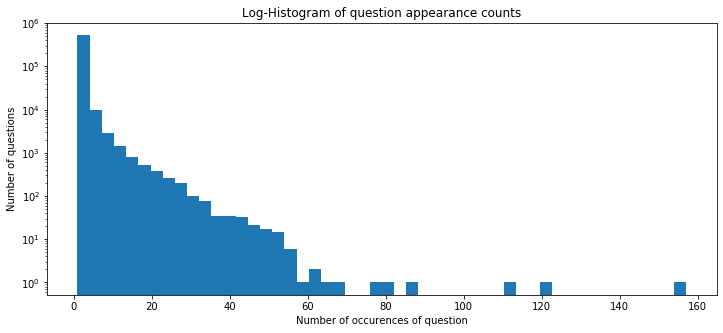

In [14]:
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
dic = qids.value_counts()
plt.figure(figsize=(12, 5))
plt.hist(dic, bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print("Number of questions: ", len(dic), ".  Number of different questions: ", len(qids), ".  Ratio: ", 100*len(dic)/len(qids), '%', sep="")

In [9]:
print(qids.head())
print("")
print(qids.tail())

0    1
1    3
2    5
3    7
4    9
dtype: int64

808575    379845
808576    155606
808577    537929
808578    537931
808579    537933
dtype: int64


### **Character study:**

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

Text(0, 0.5, 'Probability')

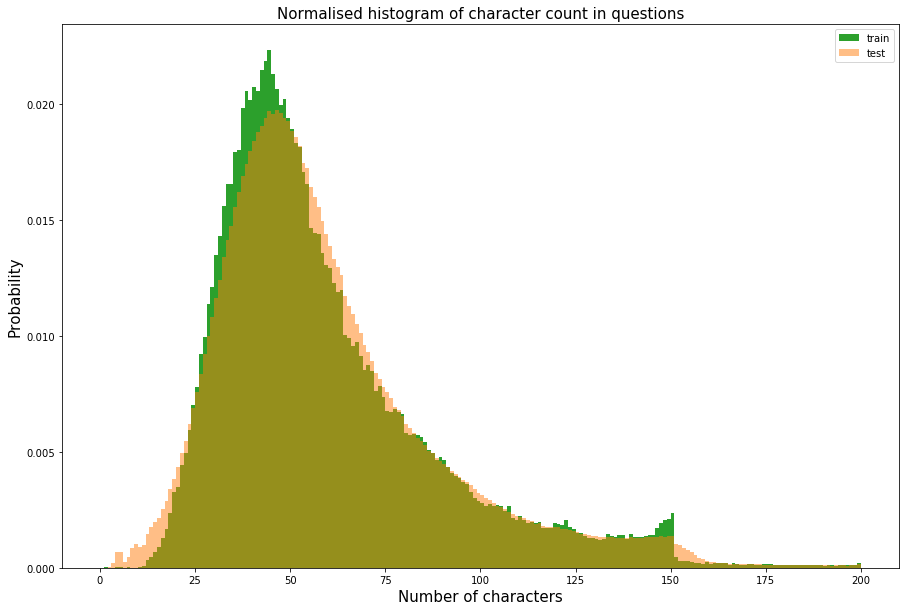

In [17]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

pal = sns.color_palette()

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], density=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], density=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### **Word study:**

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

In [ ]:
dic = qids.value_counts()

In [ ]:
from numba import jit

@jit
def f():
    m = -np.inf
    for x in train_qs:
        tok = tokenizer.encode(x)
        for w in tok:
            if w > m:
                m = w
    print(m)
f

In [34]:
m = -np.inf
for x in train_qs:
    tok = tokenizer.encode(x)
    for w in tok:
        if w > m:
            m = w
print(m)

KeyboardInterrupt: 

In [38]:
print(dist_train.head())
print(train_qs.head())
print(qids.head())

0    66
1    51
2    73
3    50
4    76
dtype: int64
0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object
0    1
1    3
2    5
3    7
4    9
dtype: int64


In [73]:
chs = [".", ":", ",", ";", "¿", "?", "¡", "!"]

In [65]:
words = []
for s in train_qs:
    for w in s.split(' '):
        words.append(w)
    
words = pd.Series(words)
dic = words.value_counts()

In [67]:
print(dic.head())

the     371820
What    292717
is      216145
I       211498
a       208427
dtype: int64


In [69]:
print("\"")

"


In [62]:
a = pd.Series(["apa afdsfa sfdsaf  dsaf a", "boc. asdfds", "caodal esftee"])
a.apply(lambda x: x.split(' '))

0    [apa, afdsfa, sfdsaf, , dsaf, a]
1                      [boc., asdfds]
2                    [caodal, esftee]
dtype: object

array([' ', 'e', 'a', ..., '问', 'š', '目'], dtype=object)

In [89]:
l = ["ets.lletja i:tonta faig,coses ho;saps ho¿saps o?no no¡passa res!eh", "hey.eh"]
#a.replace(".", "")
for a in l:
    for ch in chs:
        a = a.replace(ch, "")
    print(a)

etslletja i:tonta faig,coses ho;saps ho¿saps o?no no¡passa res!eh
etslletja itonta faig,coses ho;saps ho¿saps o?no no¡passa res!eh
etslletja itonta faigcoses ho;saps ho¿saps o?no no¡passa res!eh
etslletja itonta faigcoses hosaps ho¿saps o?no no¡passa res!eh
etslletja itonta faigcoses hosaps hosaps o?no no¡passa res!eh
etslletja itonta faigcoses hosaps hosaps ono no¡passa res!eh
etslletja itonta faigcoses hosaps hosaps ono nopassa res!eh
etslletja itonta faigcoses hosaps hosaps ono nopassa reseh
heyeh
heyeh
heyeh
heyeh
heyeh
heyeh
heyeh
heyeh


In [ ]:
def normalizar(d):
    for string in d.keys(): 
        for char in string:
            d[string] = unidecode.unidecode(d[string])
            d[string]= d[string].lower()
            d[string] = d[string].replace(" ", "")
            if char in "+":
                string = string.replace(char,'')
            for char in d[string]:
                if char in "+":
                    d[string] = d[string].replace(char,'')

    return d

In [58]:
dist_train.head()

0    66
1    51
2    73
3    50
4    76
dtype: int64

Text(0, 0.5, 'Probability')

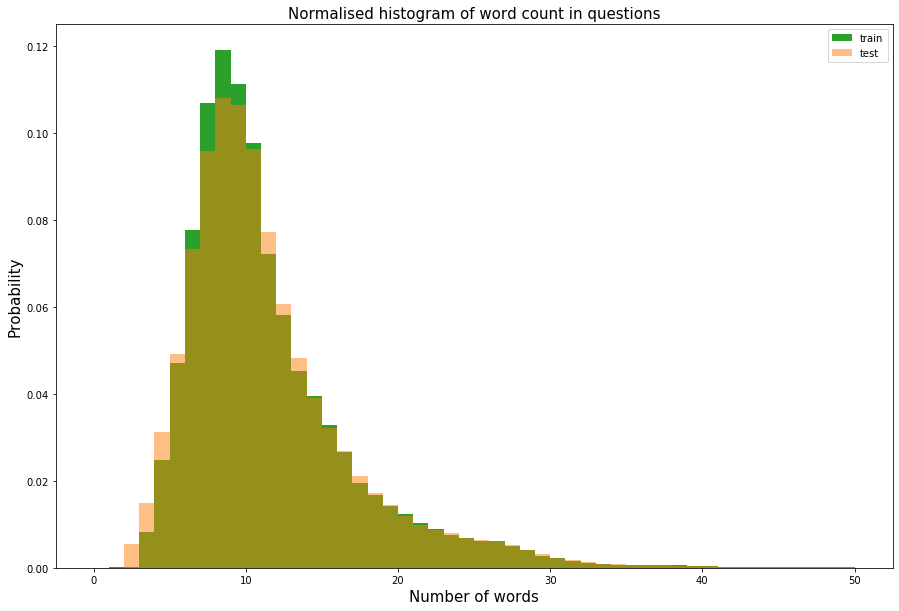

In [11]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[2], density=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[1], density=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

### **Word Cloud**

https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

(-0.5, 1439.5, 1079.5, -0.5)

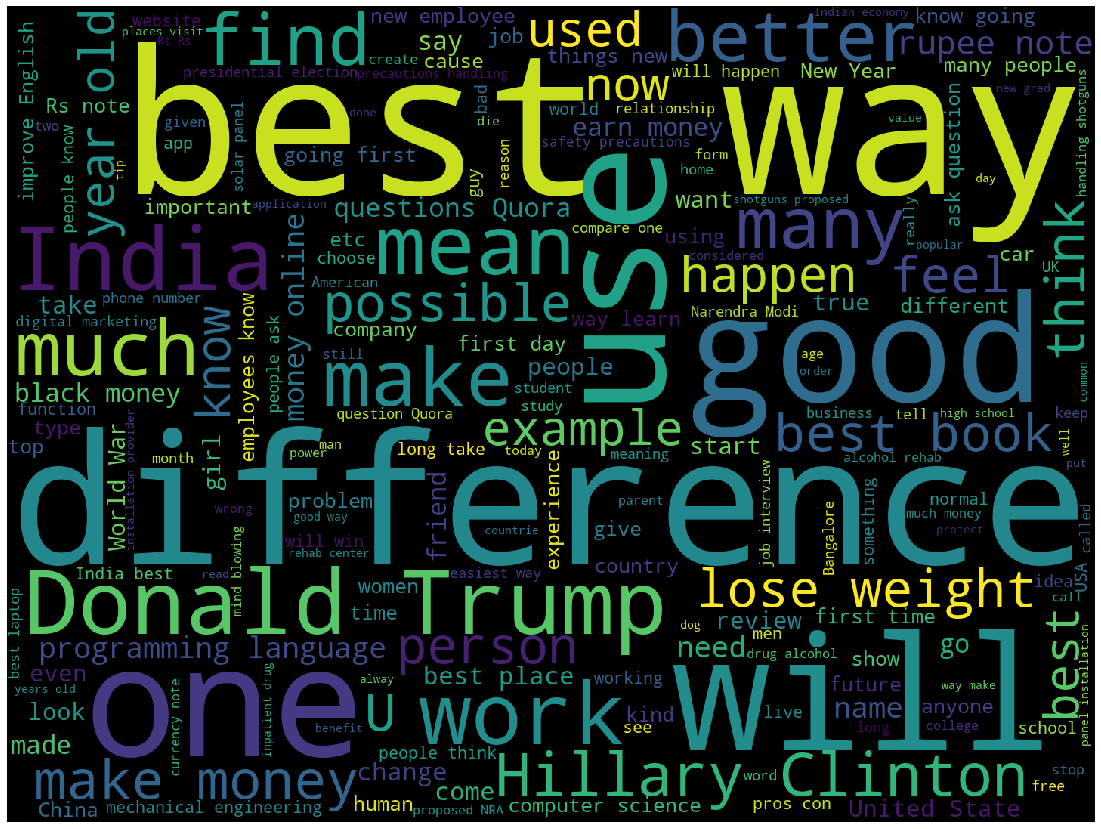

In [12]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

### **Anàlisi Semàntic**

In [15]:
qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))

IndexError: string index out of range

In [28]:
print(tokenizer.tokenize("Hola"))

['ho', '##la']
